# Project of Machine Learning : Adversarial attacks

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving cifar_net_CLASSIC_10epochs.pth to cifar_net_CLASSIC_10epochs.pth
User uploaded file "cifar_net_CLASSIC_10epochs.pth" with length 683061 bytes


In [6]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving cifar_net_AdvTRAIN_10epochs.pth to cifar_net_AdvTRAIN_10epochs.pth
User uploaded file "cifar_net_AdvTRAIN_10epochs.pth" with length 683061 bytes


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imsave(img, count=None, categorie=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if count != None and categorie != None :
        plt.savefig("{}_images_{}".format(count, categorie))
    #plt.show()

def imageshow(image):
    img = torchvision.utils.make_grid(image.to('cpu'))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

#### Clean definition of all the iterator over Data

In [9]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


def data_loading(set_data, repartition_train_valid, b_size, training=False):
  if training :
    print("Loading of Training and Validation sets !")
    datasets = train_val_dataset(set_data, repartition_train_valid)
    dataloaders = {x : torch.utils.data.DataLoader(datasets[x], batch_size=b_size, shuffle=True, num_workers=2) for x in ['train','val']}
    trainloader = dataloaders['train']
    validloader = dataloaders['val']
    return trainloader, validloader
  
  else :
    print("Loading of the Test set !")
    testloader = torch.utils.data.DataLoader(set_data, batch_size=b_size,
                                              shuffle=True, num_workers=2)
    return testloader

#### Class of our CNN

In [10]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      

    def fit(self, train_set, test_set, batch_size, nb_epochs, criterion, learning_r):
      train, valid = data_loading(train_set, 0.1, batch_size, training=True)
      test = data_loading(test_set, 0.1, batch_size, training=False)
      optimizer = optim.SGD(self.parameters(), lr=learning_r, momentum=0.9)
      
      loss_total = []
      valid_loss_total = []
      acc_total = []

      for epoch in range(nb_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        valid_loss = 0.0
        temp = []
        for i, data in enumerate(train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = self.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          nbr_ref = int(( 5400 / (batch_size / 4) ))

          if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / nbr_ref ))
              
              temp.append(running_loss/nbr_ref)
              running_loss = 0.0
        loss_total.append(np.mean(temp))
        
        with torch.no_grad():
          temp = []
          for i, data in enumerate(valid, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            # forward + backward + optimize
            outputs = self.forward(inputs)
            loss_valid = criterion(outputs, labels)

            # print statistics
            valid_loss += loss_valid.item()
            nbr_ref = int(( 600 / (batch_size / 4) ))
            if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] valid loss: %.3f' %
                    (epoch + 1, i + 1, valid_loss/nbr_ref))
              
              temp.append(valid_loss/nbr_ref)
              valid_loss = 0.0
          valid_loss_total.append(np.mean(temp))
        
        correct = 0
        total = 0
        with torch.no_grad():
          for data in test :
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc_total.append(100 * correct / total)
      print('Finished Training')
      return acc_total, loss_total, valid_loss_total



    def test(self, test_set, batch_size):
      test = data_loading(test_set, 0.1, batch_size, training=False)
      correct = 0
      total = 0
      confusion_matrix = np.zeros([10,10], int)
      with torch.no_grad():
          for data in test :
              inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
              outputs = self.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              for i, l in enumerate(labels):
                  confusion_matrix[l.item(), predicted[i].item()] += 1 

      acc_total = 100 * correct / total
      print('Accuracy of the network on the 10000 test images: %d %%' % (
          acc_total ))
      
      resultats = []
      print('{0:10s} - {1}'.format('Category','Accuracy'))
      for i, r in enumerate(confusion_matrix):
          print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
          resultats.append('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

      return acc_total, confusion_matrix, resultats

In [11]:
net = Net()
PATH = './cifar_net_CLASSIC_10epochs.pth'
net.load_state_dict(torch.load(PATH))
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

In [12]:
model_adv = Net()
PATH_adv = './cifar_net_AdvTRAIN_10epochs.pth'
model_adv.load_state_dict(torch.load(PATH_adv))
model_adv.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

## Metrics for Attacks' Quality

In [13]:
# Get an idea of the image distortion on the 3 main norms
def distortion(X_batch_tensor, X_att_tensor, DEVICE):
    
    # Unnormalize to compute norm on "real" image
    X_batch_t = X_batch_tensor / 2 + 0.5
    X_att_t = X_att_tensor / 2 + 0.5
    
    # Convert to numpy array
    X_batch_t = X_batch_t.to('cpu').numpy()
    X_att_t = X_att_t.to('cpu').numpy()  #shape (4, 3, 32, 32)
    
    # Compute 2-norm and infinite norm
    norm1, norminf = 0, 0
    for i in range(X_att_t.shape[0]):
        norm1 += np.mean(np.abs(X_att_t[i] - X_batch_t[i])) #1-norm
        norminf += np.max(np.abs(X_att_t[i] - X_batch_t[i])) #Inf-norm
    
    X_batch_tensor.to(DEVICE)
    X_att_tensor.to(DEVICE)
    
    return np.round(norm1/X_att_t.shape[0],2), np.round(norminf/X_att_t.shape[0],2)

In [14]:
def visualize_attack(attack, net, testloader, DEVICE, classes, nb=8):
    images, labels = iter(testloader).next()
    images_att = attack(net, DEVICE, images.to(DEVICE), labels.to(DEVICE), torch.nn.CrossEntropyLoss())
    pred_labels = net(images.to(DEVICE)).to('cpu').int().argmax(axis=1)
    pred_labels_att = net(images_att.to(DEVICE)).to('cpu').int().argmax(axis=1)
    
    # Print distortion of selected attacked images 
    norm2, norminf = distortion(images, images_att, DEVICE)
    
    # Convert image tensors to plot-able images 
    images, images_att = imageshow(images[0:nb]), imageshow(images_att[0:nb])
    
    fig, axes = plt.subplots(2)
    axes[0].imshow(images)
    axes[0].set_title('True labels: \n' + 
                      '   '.join('%5s' % classes[labels[j]] for j in range(nb)) +
                      '\n \nClassic CNN predictions: \n' +
                      '   '.join('%5s' % classes[pred_labels[j]] for j in range(nb)),
                      fontsize=13)
    axes[0].xaxis.set_visible(False)
    axes[0].yaxis.set_visible(False)
    
    axes[1].imshow(images_att)
    axes[1].set_title('Images under {} & Classic CNN predictions: \n'.format(attack.__name__) +
                      '(Distortion is: 1-norm: {}, inf-norm: {}) \n'.format(norm2, norminf) + 
                      '   '.join('%5s' % classes[pred_labels_att[j]] for j in range(nb)),fontsize=13)
    axes[1].xaxis.set_visible(False)
    axes[1].yaxis.set_visible(False)
    #plt.subplots_adjust(hspace=0.1)
    plt.savefig('raw_vs_attacked_{}.jpg'.format(attack.__name__), dpi=1000)
    print('Visualization for {}'.format(attack.__name__) + ' is saved under images folder.')

In [15]:
# Test attack
def test_attack(attack, attacked_cnn, classif_cnn, testloader, DEVICE, classes, corner_size=10, nb_it=7):
    net.to(DEVICE)
    
    correct = 0
    total = 0
    batch_counter = 0
    norm1, norminf = 0,0
    correct_att = 0
    confusion_matrix = np.zeros([10,10], int)
    confusion_matrix_att = np.zeros([10,10], int)
    
    for data in testloader:
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        
        if attack == corner_attack :
            inputs_att = attack(attacked_cnn, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss(), nb_it, corner_size)
        else :
            inputs_att = attack(attacked_cnn, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss(), nb_it)
        
        a,b = distortion(inputs, inputs_att, DEVICE)
        norm1 += a
        norminf += b
        batch_counter += 1

        outputs = classif_cnn(inputs)
        outputs_att = classif_cnn(inputs_att)

        _, predicted = torch.max(outputs.data, 1)
        _, predicted_att = torch.max(outputs_att.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_att += (predicted_att == labels).sum().item()
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1
            confusion_matrix_att[l.item(), predicted_att[i].item()] += 1
        
    # Print accuracy of network on raw and attacked images 
    print('Accuracy of the network on the 10000 test raw images: {} %'.format(
        100 * correct / total))
    print('Accuracy of the network on the 10000 test {}-attacked images: {} %'.format(
        attack.__name__, 100 * correct_att / total))
    
    # Print distortion of attacked images 
    print('Average distortion on images is: 1-norm: {}, inf-norm: {}'.format(
        norm1/batch_counter, norminf/batch_counter))

        
    # Plot confusion matrix for attacked images 
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix_att, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.savefig('CNN_confusion_{}.jpg'.format(attack.__name__), dpi=200) 
    print('Confusion matrix on {}-attacked images saved under training_logs folder'.format(attack.__name__))
    
    return (100 * correct_att / total)

## Accuracy performance of AdvTrained CNN against attacks

### Attacks inspired by PGD, in a targeted approach.

In [16]:
def distance_plot_delta(X_batch, X_att):
    return torch.mean( torch.norm(X_att - X_batch, dim=1) )

In [17]:
def pgd_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2 / 255, epsilon=8 / 255):
    model_cnn.to(device)
    epsilon, eta = epsilon / 0.5, eta / 0.5
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))
    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch)
        loss.backward()
        delta.data = (delta + eta * torch.sign(delta.grad.data)).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    X_att = X_batch + delta
    return X_att.detach()

In [18]:
def shift_loop(x):
    if x == 10 : 
        return 0
    else :
        return x

In [19]:
# Define attack which aims at learning the wrong label in the PGD framework

def shift_random_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2/255, epsilon=8/255):
    model_cnn.to(device)
    epsilon, eta = epsilon / 0.5, eta / 0.5
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))
    
    # Shift labels to fool the neural network
    y_att = (y_batch + 1).cpu().numpy()
    y_batch.to(device)
    y_batch_shifted = torch.tensor([shift_loop(x) for x in y_att]).to(device)
    
    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch_shifted)
        loss.backward()
        delta.data = (delta - eta*torch.sign(delta.grad.data)).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    
    X_att = X_batch + delta
    return X_att.detach()#.requires_grad_(False)

In [20]:
# Define attack which aims at learning the wrong label in the PGD framework
def shift_nearest_neuron_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2/255, epsilon=8/255) :
    model_cnn.to(device)
    epsilon, eta = epsilon / 0.5, eta / 0.5
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))

    # Shift labels to fool the neural network
    y_pred = model_cnn(X_batch)
    y_batch_shifted = torch.topk(y_pred, 2, largest=True, sorted=True).indices[:,1]

    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch_shifted)
        loss.backward()
        delta.data = (delta - eta*torch.sign(delta.grad.data)).clamp(-epsilon,epsilon)
        delta.grad.zero_()

    X_att = X_batch + delta
    return X_att.detach()#.requires_grad_(False)

In [21]:
# Define attack which aims at learning the wrong label in the PGD framework
def shift_furthest_neuron_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2/255, epsilon=8/255) :
    model_cnn.to(device)
    epsilon, eta = epsilon / 0.5, eta / 0.5
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))

    # Shift labels to fool the neural network
    y_pred = model_cnn(X_batch)
    y_batch_shifted = torch.topk(y_pred, 1, largest=False, sorted=True).indices[:,0]

    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch_shifted)
        loss.backward()
        delta.data = (delta - eta*torch.sign(delta.grad.data)).clamp(-epsilon,epsilon)
        delta.grad.zero_()

    X_att = X_batch + delta
    return X_att.detach()#.requires_grad_(False)

### Attack inspired by Carlini-wagner

In [33]:
def furthest_neuron_carlini_att(model_cnn, device, X_batch, y_batch, loss_model, nb_it=8, zeta=1.5):
    model_cnn.to(device)
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))    
    optimizer = optim.SGD([delta], lr=1, momentum=1, weight_decay=0.0005)
    
    # Shift labels to fool the neural network
    y_pred = model_cnn(X_batch)
    y_batch_shifted = torch.topk(y_pred, 1, largest=False, sorted=True).indices[:,0]
  
    for it in range(nb_it):
        optimizer.zero_grad()
        loss1 = zeta*loss_model(model_cnn(X_batch + delta), y_batch_shifted)
        loss2 = torch.norm(delta, p=2)
        total_loss = sum([loss1, loss2])
        total_loss.backward()
        optimizer.step()
  
    X_att = X_batch + delta
    return X_att.detach()

### Local : Corner attack

In [25]:
def corner_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=10, corner_size=10):
    model_cnn.to(device)
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
   
    batch_size = X_batch.shape[0]
    corner = torch.zeros((batch_size,3,corner_size,corner_size), device=device).requires_grad_(True)
    zerosleft = torch.zeros((batch_size,3,corner_size,32-corner_size), device=device).requires_grad_(False)
    bottom = torch.cat((zerosleft, corner), dim=3).requires_grad_(True)
    top = torch.zeros((batch_size,3,32-corner_size,32), device=device).requires_grad_(False)
    delta = torch.cat((top, bottom), dim=2).requires_grad_(True)
   
    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch)
        loss.backward()
        corner.data = (corner + eta*torch.sign(corner.grad.data))#.clamp(-epsilon,epsilon)
        corner.grad.zero_()
       
    with torch.no_grad():
        bottom = torch.cat((zerosleft, corner), dim=3)
        delta = torch.cat((top, bottom), dim=2)
        X_att = X_batch + delta
   
    return X_att.detach() 

### Differents plots of attacks



Study of <function pgd_attack at 0x7f37001631e0>  on 1 loss, classified by 0.
Accuracy of the network on the 10000 test raw images: 54.0 %
Accuracy of the network on the 10000 test pgd_attack-attacked images: 66.72 %
Average distortion on images is: 1-norm: 0.02000000000000001, inf-norm: 0.03000000000000002
Confusion matrix on pgd_attack-attacked images saved under training_logs folder


Study of <function furthest_neuron_carlini_att at 0x7f36ee2321e0>  on 1 loss, classified by 0.
Accuracy of the network on the 10000 test raw images: 54.28 %
Accuracy of the network on the 10000 test furthest_neuron_carlini_att-attacked images: 54.43 %
Average distortion on images is: 1-norm: 0.00075, inf-norm: 0.017250000000000005
Confusion matrix on furthest_neuron_carlini_att-attacked images saved under training_logs folder


Study of <function corner_attack at 0x7f36ee150f28>  on 1 loss, classified by 0.
Accuracy of the network on the 10000 test raw images: 54.14 %
Accuracy of the network on the 1

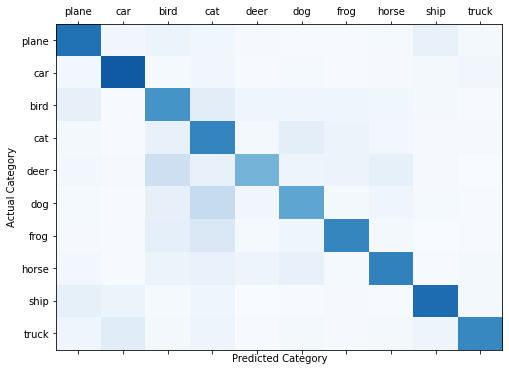

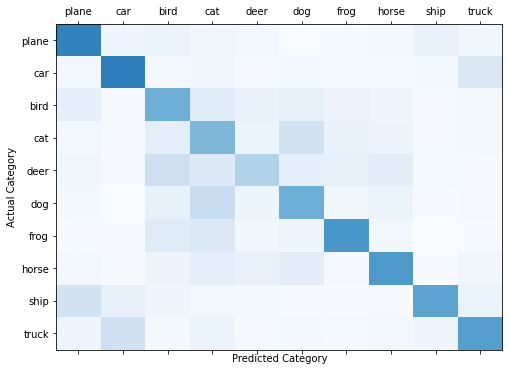

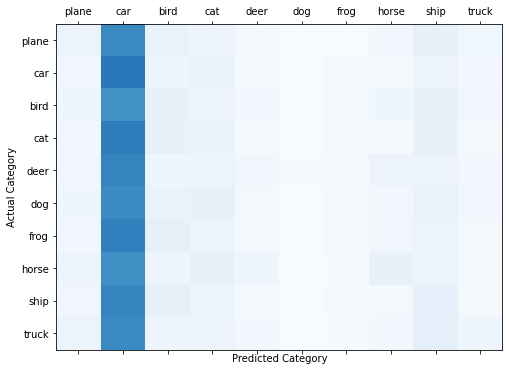

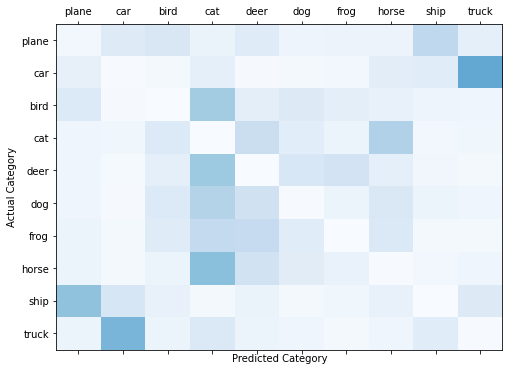

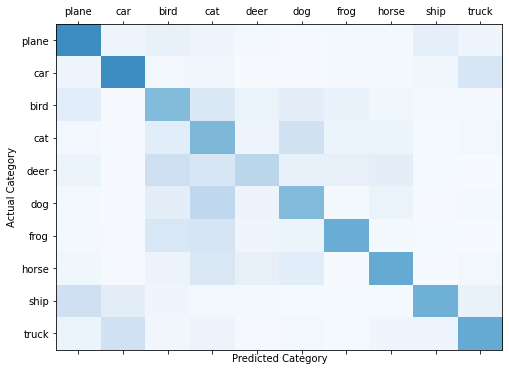

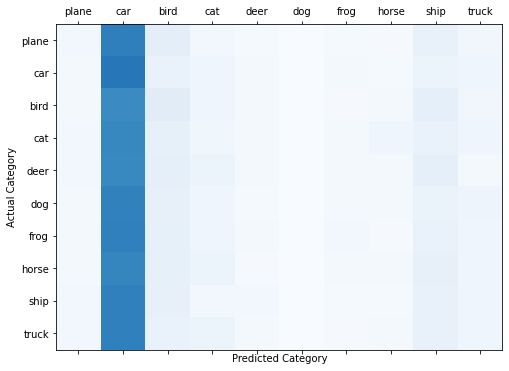

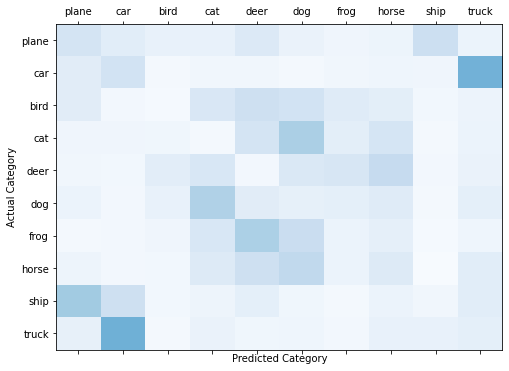

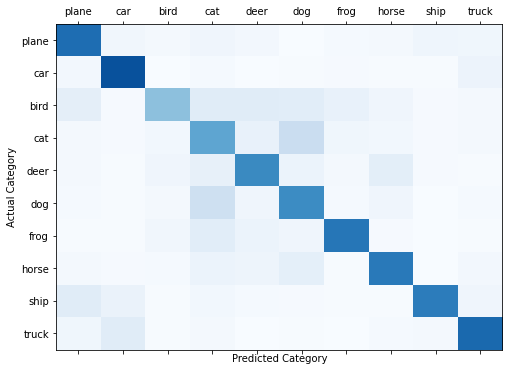

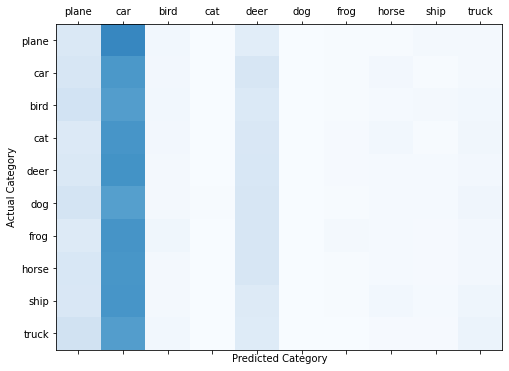

In [34]:
for network_classif in [model_adv, net] :
    for network_attacked in [net, model_adv] :
        
        if network_attacked == model_adv and network_classif == net :
            break
        else :
            for a in [pgd_attack, furthest_neuron_carlini_att, corner_attack] :
                
                print('\n')
                print('Study of {}  on {} loss, classified by {}.'.format(a, [model_adv, net].index(network_attacked), [model_adv, net].index(network_classif)))
                acc = test_attack(a, network_attacked, network_classif, testloader, DEVICE, classes)

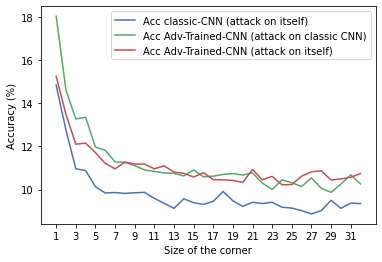

In [ ]:
plt.style.use('seaborn-deep')
plt.plot(accs[0][1:], label="Acc classic-CNN (attack on itself)")
plt.plot(accs[1][1:], label="Acc Adv-Trained-CNN (attack on classic CNN)")
plt.plot(accs[2][1:], label="Acc Adv-Trained-CNN (attack on itself)")
plt.legend()
plt.xlabel("Size of the corner")
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(0, 32, 2), range(1, 33, 2))
plt.savefig("CORNER_ACCURACIES_31.png", dpi=1000)
plt.show()

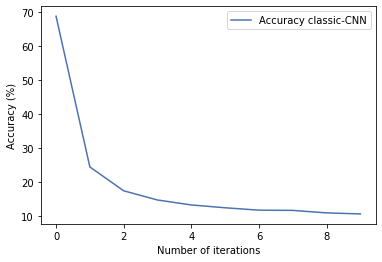

In [ ]:
plt.style.use('seaborn-deep')
plt.plot(accu[:10], label="Accuracy classic-CNN")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy (%)")
plt.savefig("Nb_it_CORNER_ACCURACIES_32.png", dpi=1000)
plt.show()

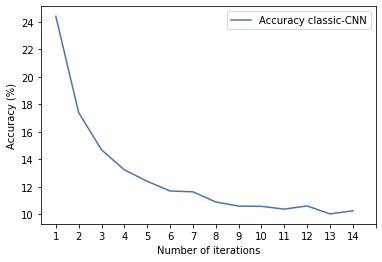

In [ ]:
plt.style.use('seaborn-deep')
plt.plot(accu[1:15], label="Accuracy classic-CNN")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(0, 15, 1), range(1, 15))
plt.savefig("Nb_it_CORNER_ACCURACIES_31.png", dpi=1000)
plt.show()